# Contraste de Grupos

In [4]:
pkg = c("tidyverse", "tidymodels", "e1071", "ggpubr", "ggsci")

for (i in pkg) {
  if(eval(bquote(!require(.(i))))) eval(bquote(install.packages(.(i))))
}

Loading required package: e1071


Attaching package: ‘e1071’


The following objects are masked from ‘package:moments’:

    kurtosis, moment, skewness


The following object is masked from ‘package:tune’:

    tune


The following object is masked from ‘package:rsample’:

    permutations


The following object is masked from ‘package:parsnip’:

    tune




In [5]:
library(haven)

df = read_spss("https://github.com/renatoparedes/EstadisticaYPsicologiaMatematica/raw/main/INEE/Clase7_BaseContrasteDeGrupos.sav")
df

Código,Sexo,Pretest,Postest
<chr>,<dbl+lbl>,<dbl>,<dbl>
001,1,30,27
002,2,24,23
003,2,22,18
004,1,30,18
005,2,26,20
006,1,24,25
007,1,24,21
008,1,22,17
009,2,18,18


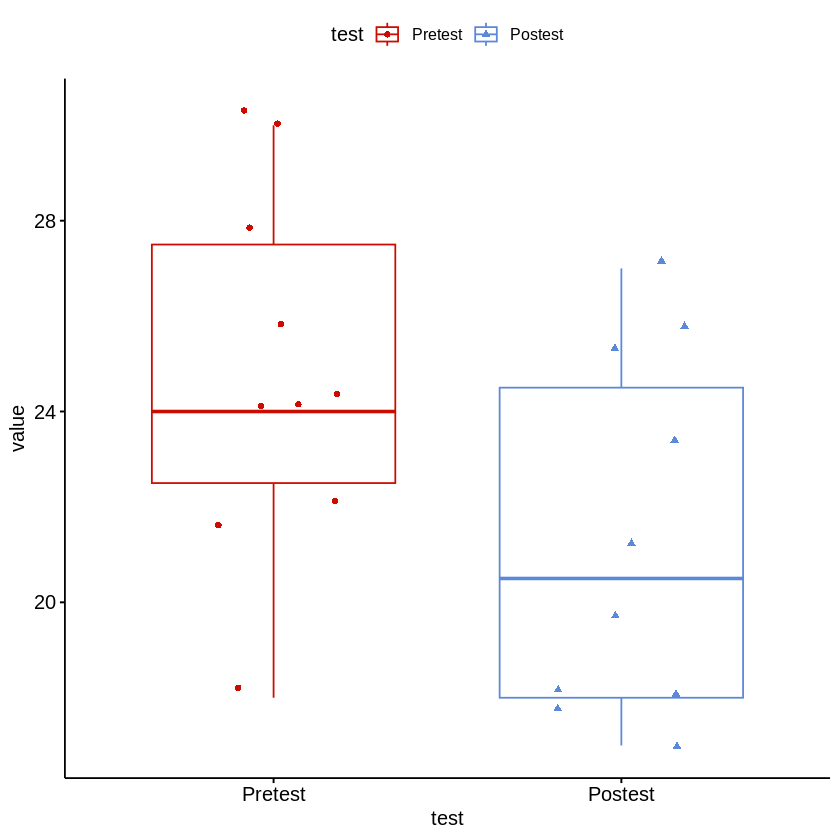

In [6]:
library(ggpubr)
library(tidyverse)
library(ggsci)

df %>%
  pivot_longer(-c(1:2), names_to = "test", values_to = "value") %>%
  ggboxplot(x = "test", y = "value", 
            color = "test", shape = "test", add = "jitter") +
  scale_color_startrek()

# Descripción de los datos

In [7]:
df %>%
  pivot_longer(-c(1:2), names_to = "test", values_to = "value") %>%
  group_by(test) %>%
  reframe(n = n(),
            mean  = mean(value, na.rm = T),
            std   = sd(value, na.rm = T),
            min   = min(value, na.rm = T),
            max   = max(value, na.rm = T),
            nquan = c("25%", "50%", "75%"),
            quan  = quantile(value, c(.25, .50, .75), na.rm = T)) %>%
  pivot_wider(names_from = nquan, values_from = quan)

test,n,mean,std,min,max,25%,50%,75%
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Postest,10,21.3,3.713339,17,27,18.0,20.5,24.5
Pretest,10,24.8,3.794733,18,30,22.5,24.0,27.5


# Análisis de Normalidad

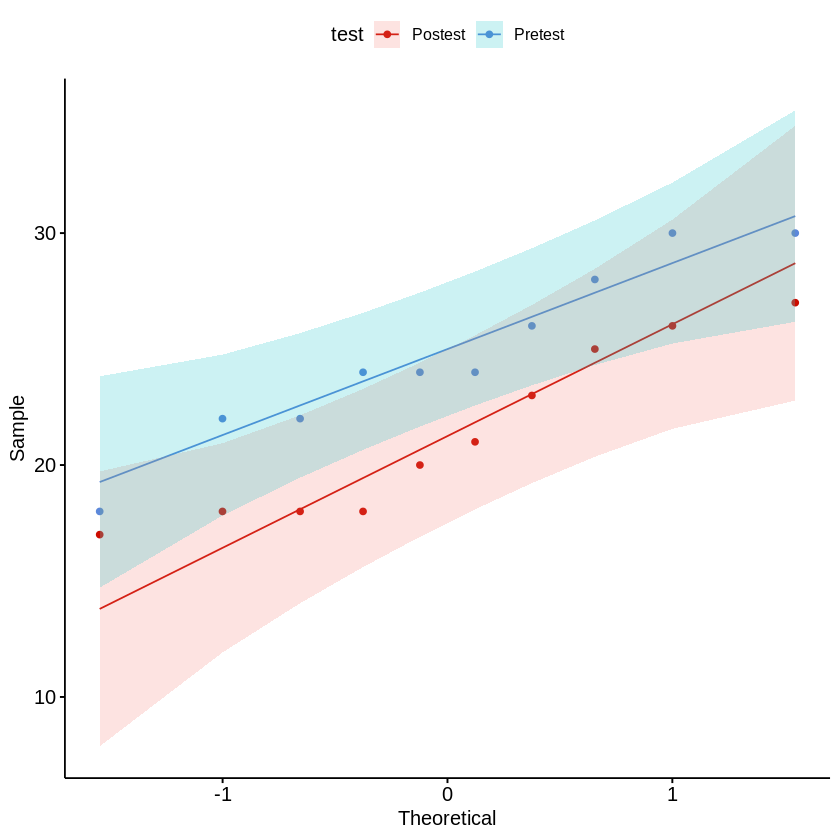

In [8]:
df %>%
  pivot_longer(-c(1:2), names_to = "test", values_to = "value") %>%
  ggqqplot(x = "value", color = "test") +
  scale_color_startrek()

In [9]:
df %>% 
  pivot_longer(-c(1:2), names_to = "test", values_to = "value") %>%
  group_by(test) %>%
  summarise(W = shapiro.test(value)$statistic,
            p = shapiro.test(value)$p.value,
            normal = case_when(p <= .05 ~ F, p > .05 ~ T))

test,W,p,normal
<chr>,<dbl>,<dbl>,<lgl>
Postest,0.8923593,0.1802463,TRUE
Pretest,0.9418100,0.5733240,TRUE


In [10]:
library(e1071)

df %>%
  pivot_longer(-c(1:2), names_to = "test", values_to = "value") %>%
  group_by(test) %>%
  summarise(Asimetría = e1071::skewness(value, type = 2),
            Curtosis = e1071::kurtosis(value, type = 2))

test,Asimetría,Curtosis
<chr>,<dbl>,<dbl>
Postest,0.4205497,-1.5385768
Pretest,-0.1122413,-0.3064374


Ambas distribuciones se aproximan a la distribución normal. Por tanto, corresponde usar índice paramétrico t para dos muestras relacionadas.

# Contraste de muestras relacionadas

In [11]:
library(rstatix)

df %>%
  pivot_longer(-c(1:2), names_to = "test", values_to = "value") %>%
  t_test(value ~ test, paired = T)


Attaching package: ‘rstatix’


The following objects are masked from ‘package:infer’:

    chisq_test, prop_test, t_test


The following object is masked from ‘package:dials’:

    get_n


The following object is masked from ‘package:stats’:

    filter




,.y.,group1,group2,n1,n2,statistic,df,p
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,value,Postest,Pretest,10,10,-3,9,0.015


De acuerdo al análisis de contraste se observa una diferencia significativa en el puntaje de ansiedad entre la evaluación pre-test y la de post-test, t(9)=3.00, p=.02. De manera específica, se observa una reducción en ansiedad pre-test (M=24.8, DE=3.80) al post-test (M=21.3, DE=3.71) reportada por las/los participantes.

# Contraste de muestras independientes

In [12]:
df_ind = df %>% select(Sexo, Postest) %>% mutate(Sexo = as_factor(Sexo))
df_ind

Sexo,Postest
<fct>,<dbl>
Mujer,27
Hombre,23
Hombre,18
Mujer,18
Hombre,20
Mujer,25
Mujer,21
Mujer,17
Hombre,18


In [13]:
df_ind %>%
  group_by(Sexo) %>%
  reframe(n = n(),
            mean  = mean(Postest, na.rm = T),
            std   = sd(Postest, na.rm = T),
            min   = min(Postest, na.rm = T),
            max   = max(Postest, na.rm = T),
            nquan = c("25%", "50%", "75%"),
            quan  = quantile(Postest, c(.25, .50, .75), na.rm = T)) %>%
  pivot_wider(names_from = nquan, values_from = quan)

Sexo,n,mean,std,min,max,25%,50%,75%
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mujer,6,22.33333,4.273952,17,27,18.75,23,25.75
Hombre,4,19.75000,2.362908,18,23,18.00,19,20.75


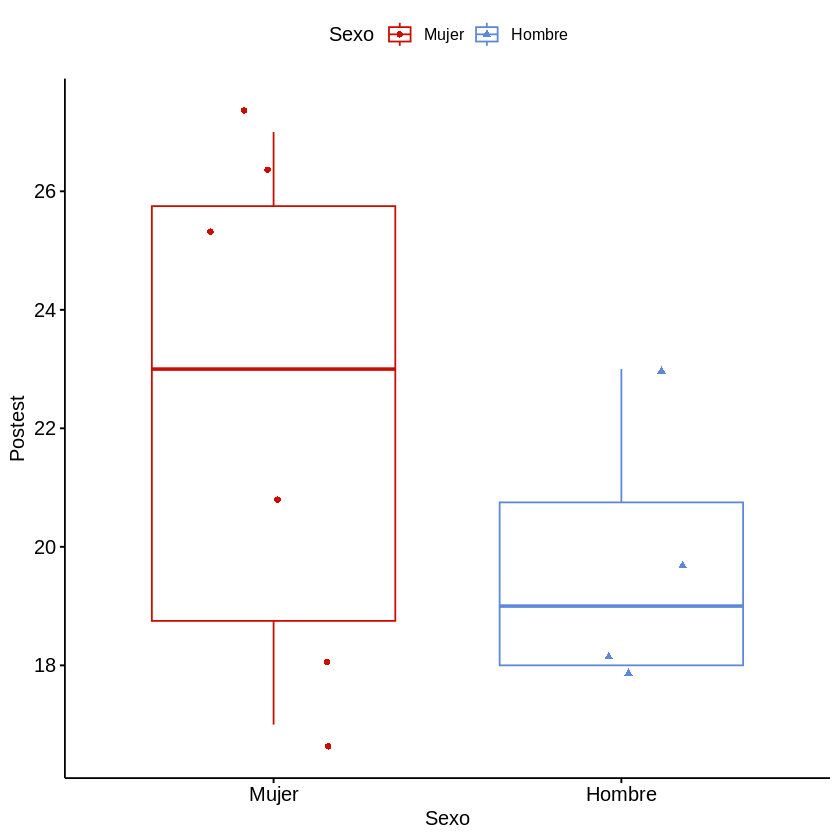

In [14]:
df_ind %>%
  ggboxplot(x = "Sexo", y = "Postest", 
            color = "Sexo", shape = "Sexo", add = "jitter") +
  scale_color_startrek()

In [15]:
df_ind %>% 
  group_by(Sexo) %>%
  summarise(W = shapiro.test(Postest)$statistic,
            p = shapiro.test(Postest)$p.value,
            normal = case_when(p <= .05 ~ F, p > .05 ~ T))

Sexo,W,p,normal
<fct>,<dbl>,<dbl>,<lgl>
Mujer,0.8924716,0.3313410,TRUE
Hombre,0.8480787,0.2199986,TRUE


Ambas distribuciones se aproximan a la normalidad. Corresponde usar índice paramétrico t para dos muestras independientes.

In [16]:
df_ind %>%
  levene_test(Postest ~ Sexo)

df1,df2,statistic,p
<int>,<int>,<dbl>,<dbl>
1,8,3.512033,0.09779746


El resultado de la prueba de Levene no es significativo, F=4.65, p=.06, por lo que se asumen varianzas iguales entre el grupo de mujeres y el de hombres.

In [17]:
df_ind %>%
  summarize(statistic = t_test(., Postest ~ Sexo, var.equal = T)$statistic,
            dof = t_test(., Postest ~ Sexo, var.equal = T)$df,
            p = t_test(., Postest ~ Sexo, var.equal = T)$p,
            cohens_d = cohens_d(., Postest ~ Sexo, var.equal = T)$effsize)

statistic,dof,p,cohens_d
<dbl>,<dbl>,<dbl>,<dbl>
1.088809,8,0.308,0.7028232


No se observa una diferencia en ansiedad según el sexo de las y los participantes, t(8)=1.09, p=.31. Los puntajes de ansiedad reportados no difieren entre mujeres (M=22.33, DE=4.27) y hombres (M=19.75, DE=2.36).

# Contraste global

In [18]:
df2 = haven::read_spss("https://github.com/renatoparedes/EstadisticaYPsicologiaMatematica/raw/main/INEE/Clase6_BaseEstadisticaDescriptiva.sav")
df2

Código,Sexo,Edad,EstadoCivil,NúmHermanos,OrdenHermanos,Religión,LugarNac,IntFamiliar,Instrucción,EstLaboral,EPA1,EPA2,EPA3,EPA4,EPA5,EPA6
<chr>,<dbl+lbl>,<dbl>,<dbl+lbl>,<dbl>,<dbl>,<chr>,<dbl+lbl>,<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>
001,0,20,0,2,1,Católica,0,4,5,0,4,1,3,3,4,3
002,1,18,0,2,1,Católica,0,5,7,1,5,2,4,4,4,5
003,1,19,1,3,2,Católica,0,5,7,1,3,3,2,2,3,2
004,0,18,0,3,2,Evangélico,1,3,7,1,5,3,2,4,3,4
005,1,19,1,2,2,Cristiana,0,5,7,1,1,1,1,2,2,1
006,1,19,4,2,1,Católica,0,7,7,1,3,1,2,5,3,3
007,0,19,4,2,1,Cristiana,0,5,7,1,3,2,3,5,5,1
008,0,22,0,4,3,Ateo,1,4,7,0,4,3,4,5,5,2
009,0,21,0,2,1,Católica,0,5,8,0,2,1,2,2,2,1


In [19]:
df2 %>%
  mutate(EPA3 = (6 - EPA3) %>% 
                        labelled(c("Nunca" = 5, 
                                   "Pocas veces" = 4, 
                                   "Algunas veces" = 3, 
                                   "Muchas veces" = 2, 
                                   "Siempre" = 1)),
         Instrucción = case_when(Instrucción %in% c(0, 1) ~ "Sin estudios, inicial o primaria",
                                 Instrucción %in% c(3, 4) ~ "Secundaria",
                                 Instrucción %in% c(5, 6) ~ "Superior Técnica",
                                 Instrucción %in% c(7, 8) ~ "Superior Universitaria"),
         Procrastinacion = rowMeans(across(EPA1:EPA6), na.rm = T)) -> df2

df2

Código,Sexo,Edad,EstadoCivil,NúmHermanos,OrdenHermanos,Religión,LugarNac,IntFamiliar,Instrucción,EstLaboral,EPA1,EPA2,EPA3,EPA4,EPA5,EPA6,Procrastinacion
<chr>,<dbl+lbl>,<dbl>,<dbl+lbl>,<dbl>,<dbl>,<chr>,<dbl+lbl>,<dbl>,<chr>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl>
001,0,20,0,2,1,Católica,0,4,Superior Técnica,0,4,1,3,3,4,3,3.000000
002,1,18,0,2,1,Católica,0,5,Superior Universitaria,1,5,2,2,4,4,5,3.666667
003,1,19,1,3,2,Católica,0,5,Superior Universitaria,1,3,3,4,2,3,2,2.833333
004,0,18,0,3,2,Evangélico,1,3,Superior Universitaria,1,5,3,4,4,3,4,3.833333
005,1,19,1,2,2,Cristiana,0,5,Superior Universitaria,1,1,1,5,2,2,1,2.000000
006,1,19,4,2,1,Católica,0,7,Superior Universitaria,1,3,1,4,5,3,3,3.166667
007,0,19,4,2,1,Cristiana,0,5,Superior Universitaria,1,3,2,3,5,5,1,3.166667
008,0,22,0,4,3,Ateo,1,4,Superior Universitaria,0,4,3,2,5,5,2,3.500000
009,0,21,0,2,1,Católica,0,5,Superior Universitaria,0,2,1,4,2,2,1,2.000000


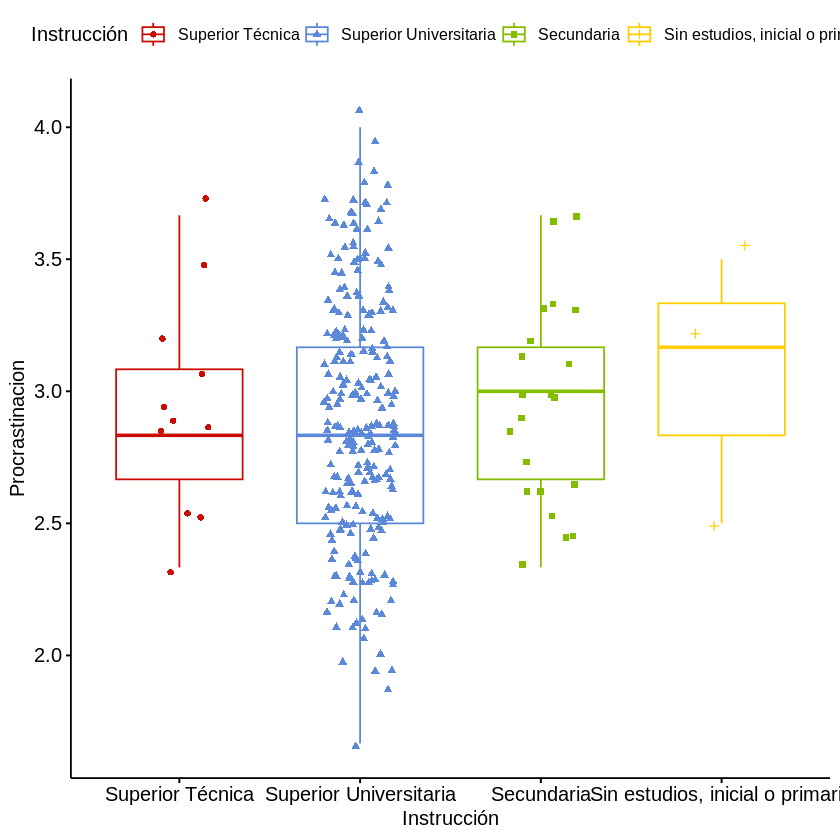

In [20]:
df2 %>%
  ggboxplot(x = "Instrucción", y = "Procrastinacion", 
            color = "Instrucción", shape = "Instrucción", 
            add = "jitter") +
  scale_color_startrek()

In [21]:
df2 %>% 
  anova_test(Procrastinacion ~ Instrucción, detailed = T)

,Effect,SSn,SSd,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Instrucción,0.136,58.201,3,284,0.222,0.881,,0.002


No se encontraron diferencias significativas en procrastinación global según nivel de instrucción de las y los participantes, F(3,284) = 0.22, p = .88. Este resultado indicaría que la postergación de tareas o el dejar para después las actividades en el día a día no se distingue en función al nivel educativo reportado.

In [22]:
df2 %>%
  tukey_hsd(Procrastinacion ~ Instrucción)

,term,group1,group2,null.value,estimate,conf.low,conf.high,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Instrucción,Secundaria,"Sin estudios, inicial o primaria",0,0.10317460,-0.6189084,0.8252576,0.983,ns
2,Instrucción,Secundaria,Superior Técnica,0,-0.02813853,-0.4635709,0.4072939,0.998,ns
3,Instrucción,Secundaria,Superior Universitaria,0,-0.05580651,-0.3214855,0.2098724,0.948,ns
4,Instrucción,"Sin estudios, inicial o primaria",Superior Técnica,0,-0.13131313,-0.8933199,0.6306936,0.970,ns
5,Instrucción,"Sin estudios, inicial o primaria",Superior Universitaria,0,-0.15898112,-0.8384207,0.5204585,0.931,ns
6,Instrucción,Superior Técnica,Superior Universitaria,0,-0.02766798,-0.3879952,0.3326593,0.997,ns
